In [107]:
import os
import traceback
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from concurrent.futures import ProcessPoolExecutor
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

In [108]:
# Desactivar el uso de la GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [109]:
# Función para extraer fotogramas.
def extraer_fotogramas(video_path, output_folder, num_frames=50):
    # Crear la carpeta de salida si no existe.
    os.makedirs(output_folder, exist_ok=True)
    
    # Contar los fotogramas existentes.
    existing_frames = sum(1 for _ in os.scandir(output_folder) \
        if _.name.endswith('.jpg'))
    
    # Si ya hay suficientes fotogramas generados, no hacer nada.
    if existing_frames >= num_frames:
        print(f"Fotogramas ya generados para {video_path}. Omitiendo.\n")
        return
        
    # Cargar el video.
    video = cv2.VideoCapture(video_path)

    # Obtener el número total de fotogramas del video.
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calcular el intervalo entre fotogramas.
    interval = max(1, total_frames // num_frames)

    saved_frames = 0
    for count in range(0, total_frames, interval):
        # Establecer el fotograma a capturar.
        video.set(cv2.CAP_PROP_POS_FRAMES, count)
        success, frame = video.read()

        if success:
            # Guardar el fotograma como imagen.
            output_path = os.path.join(output_folder,
                f"frame_{saved_frames}.jpg")
            cv2.imwrite(output_path, frame)
            saved_frames += 1

            # Detener cuando se haya guardado el número deseado de fotogramas.
            if saved_frames >= num_frames:
                break
        else:
            break
    
    video.release()

In [110]:
# Función para procesar varios videos en paralelo.
def procesar_videos(videos, output_root_folder="./files/frames",
    num_frames=50):
    with ProcessPoolExecutor() as executor:
        futures = []

        # Extraer fotogramas para cada video.
        for video in videos:
            try:
                # Obtener el nombre del video.
                video_name = os.path.splitext(os.path.basename(video))[0]
                output_folder = os.path.join(output_root_folder, video_name)
                futures.append(executor.submit(extraer_fotogramas, video,
                    output_folder, num_frames))
            except Exception as e:
                print(f"Error al procesar el video {video}: {e}")
                traceback.print_exc()
        # Esperar a que todas las tareas se completen
        for future in futures:
            future.result()

In [111]:
# Función para procesar imágenes y etiquetas.
def procesar_imagenes(folder_path, image_size=(128, 128)):
    # Variables para almacenar imágenes y etiquetas.
    imagenes, etiquetas, nombres_imagenes = [], [], []

    # Obtener las clases (subdirectorios) y ordenarlas.
    class_names = sorted(os.listdir(folder_path))
    class_to_index = {class_name: idx for idx,
        class_name in enumerate(class_names)}
    
    # Asignación de índices a nombres de clase.
    index_to_class = {idx: class_name for class_name,
        idx in class_to_index.items()}
    
    # Recorrer cada clase y archivo de imagen.
    for class_name, class_idx in class_to_index.items():
        class_folder = os.path.join(folder_path, class_name)

        # Filtrar solo archivos de imágenes.
        image_files = [f for f in os.listdir(class_folder) \
            if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
        
        # Procesar imágenes de cada clase.
        for image_name in image_files:
            image_path = os.path.join(class_folder, image_name)
            with Image.open(image_path) as image:
                image = image.resize(image_size) # Redimensionar la imagen.

                # Normalizar (entre 0 y 1).
                image_array = np.array(image) / 255.0

            imagenes.append(image_array)
            etiquetas.append(class_idx)
            nombres_imagenes.append(image_name)
    
    return np.array(imagenes), np.array(etiquetas), nombres_imagenes, \
        index_to_class

In [112]:
# Rutas de los videos.
videos = [
    "./files/arbol.mp4",
    "./files/bote.mp4",
    "./files/carro.mp4",
    "./files/escoba.mp4",
    "./files/regadera.mp4"
]

# Procesar los videos.
procesar_videos(videos)

# Procesar las imágenes extraidas.
imagenes, etiquetas, nombres_imagenes, index_to_class \
    = procesar_imagenes("./files/frames")

# Dividir las imágenes en datos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas,
    test_size=0.2, stratify=etiquetas, random_state=42)

Fotogramas ya generados para ./files/arbol.mp4. Omitiendo.
Fotogramas ya generados para ./files/bote.mp4. Omitiendo.
Fotogramas ya generados para ./files/carro.mp4. Omitiendo.
Fotogramas ya generados para ./files/escoba.mp4. Omitiendo.
Fotogramas ya generados para ./files/regadera.mp4. Omitiendo.







In [113]:
# Crear el modelo.
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax') # 5 clases
])

In [114]:
# Compilar el modelo.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [115]:
# Entrenar el modelo.
model.fit(X_train, y_train, epochs=5, batch_size=4)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5663 - loss: 1.3271
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9710 - loss: 0.0619
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9729 - loss: 0.1279
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 3.3187e-04


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


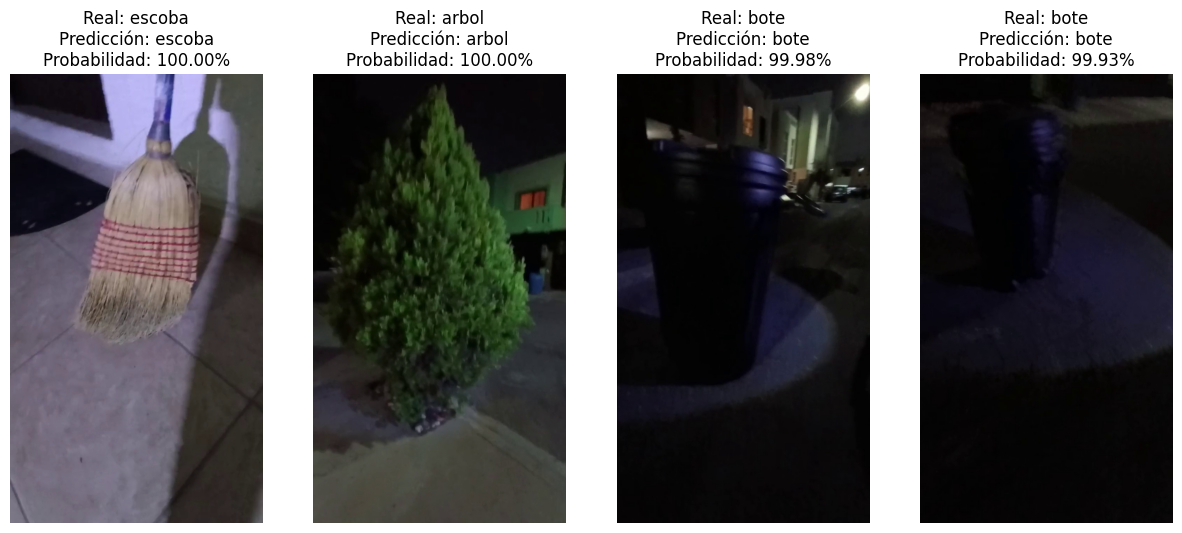

In [116]:
# Predecir las clases para las imágenes de prueba.
predicciones = model.predict(X_test)

# Convertir las predicciones en clases.
predicciones_clase = np.argmax(predicciones, axis=1)

# Mostrar algunas imágenes de prueba junto con sus etiquetas verdaderas y
# predicciones.
num_ejemplos = 4
plt.figure(figsize=(15, 7))

for i in range(num_ejemplos):
    # Obtener la etiqueta real y la predicción.
    etiqueta_real = index_to_class[y_test[i]] # nombre real de la clase

    # Nombre real de la clase predicha.
    prediccion = index_to_class[predicciones_clase[i]]

    # Obtener la probabilidad más alta.
    probabilidad = predicciones[i][predicciones_clase[i]]

    plt.subplot(1, num_ejemplos, i + 1)

    # Mostrar la imagen original
    original_image = Image.open(os.path.join("./files/frames", etiqueta_real,
        nombres_imagenes[i]))
    plt.imshow(original_image)
    plt.axis('off')

    # Mostrar las etiquetas.
    plt.title(f'Real: {etiqueta_real}\nPredicción: {prediccion}\n' +
        f'Probabilidad: {probabilidad * 100:.2f}%')

plt.show()

In [117]:
# Evaular el modelo con los datos de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Pérdida en los datos de prueba: {test_loss}")
print(f"Exactitud en los datos de prueba: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 3.3288e-04 
Pérdida en los datos de prueba: 0.0003154993464704603
Exactitud en los datos de prueba: 100.00%


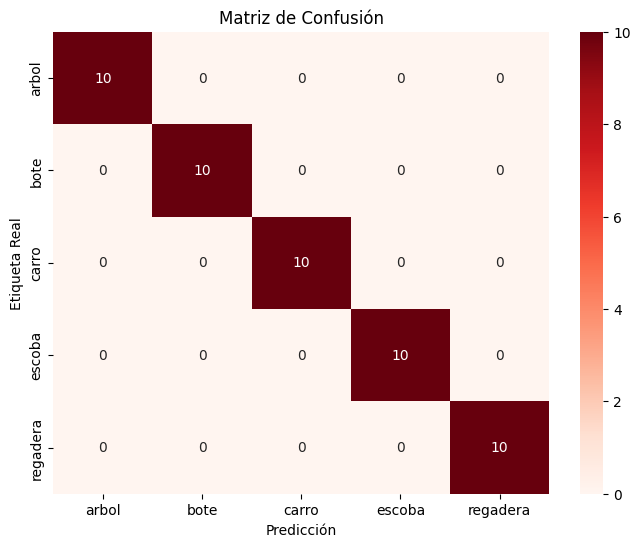

In [118]:
# Crear una matriz de confusión
cm = confusion_matrix(y_test, predicciones_clase)

# Obtener los nombres de las clases
class_names = [index_to_class[i] for i in range(len(index_to_class))]

# Ver la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Verificar la estructura de las capas del modelo.
for idx, layer in enumerate(model.layers):
    print(f"Índice: {idx}, Capa: {layer.name}")

Índice: 0, Capa: conv2d_12
Índice: 1, Capa: max_pooling2d_12
Índice: 2, Capa: conv2d_13
Índice: 3, Capa: max_pooling2d_13
Índice: 4, Capa: flatten_6
Índice: 5, Capa: dense_12
Índice: 6, Capa: dense_13


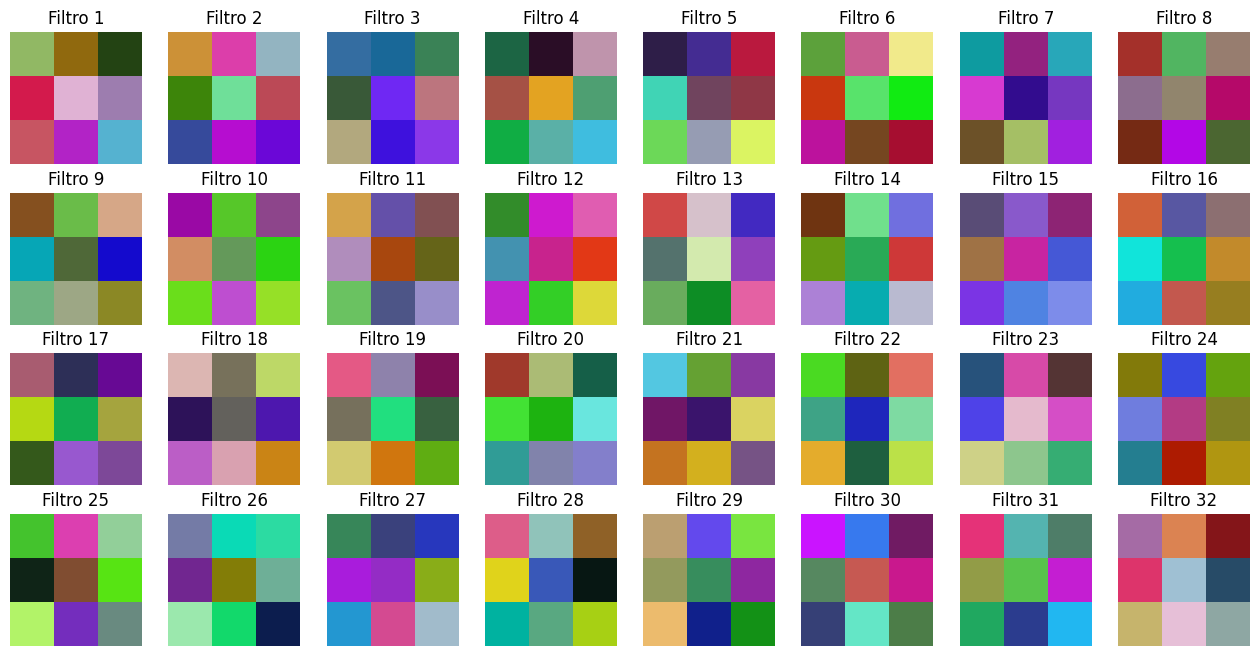

In [162]:
# Obtener los filtros de la primera capa convolucional.
conv1_filters = model.layers[0].get_weights()[0]

# Normalizar los filtros al rango [0, 1].
conv1_filters = (conv1_filters - np.min(conv1_filters)) / \
    (np.max(conv1_filters) - np.min(conv1_filters))

# Número de filtros.
num_filters = conv1_filters.shape[-1]

# Definir el número de filas y columnas para mostrar los filtros.
n_cols, n_rows = 8, num_filters // 8

# Crear una figura para mostrar los filtros.
plt.figure(figsize=(n_cols * 2, n_rows * 2))

# Mostrar cada filtro como una imagen.
for i in range(num_filters):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(conv1_filters[:, :, :, i], cmap='gray')
    plt.axis('off')
    plt.title(f'Filtro {i+1}')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


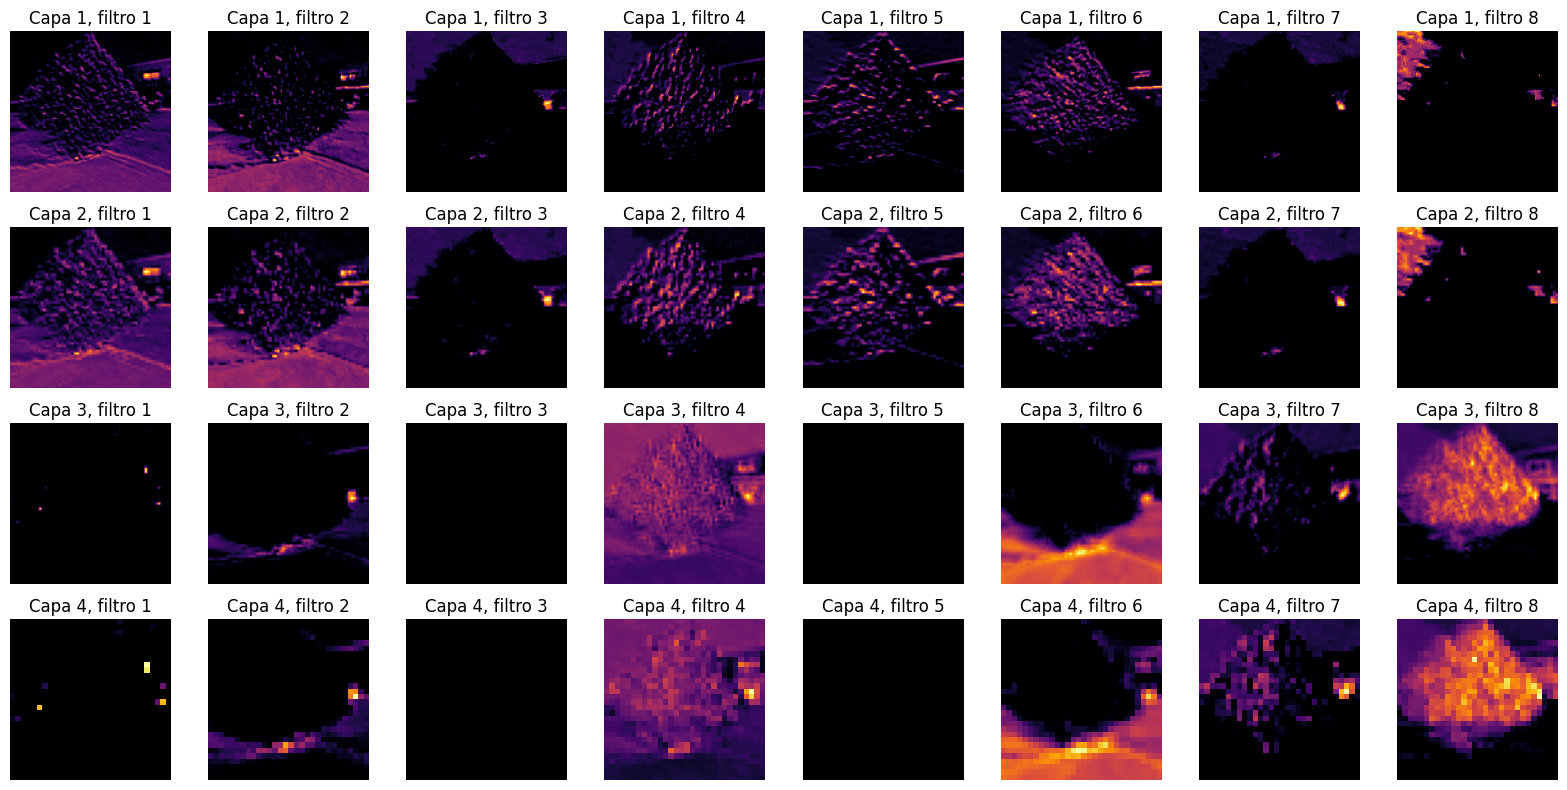

In [163]:
# Tomar una imagen de ejemplo del conjunto de datos de prueba.
example_image = np.expand_dims(imagenes[1], axis=0)

# Crear un modelo que devuelve las activaciones de cada capa.
activation_model = Model(inputs=model.inputs[0],
    outputs=[layer.output for layer in model.layers])

# Obtener las activaciones para esta imagen.
activations = activation_model.predict(example_image)

# Definir el máximo de filtros a mostrar por capa.
max_filters_per_layer = 8

# Calcular el número total de filtros a mostrar.
total_filters = sum(min(layer_activations.shape[-1], max_filters_per_layer) \
    for layer_activations in activations if len(layer_activations.shape) == 4)

# Filas necesarias.
n_rows = (total_filters // n_cols) + (1 if total_filters % n_cols != 0 else 0)

# Crear una figura para mostrar las activaciones
plt.figure(figsize=(n_cols * 2, n_rows * 2))

# Variable para contar los filtros.
filter_idx_total = 1

# Mostrar las activaciones de cada capa.
for layer_idx, layer_activations in enumerate(activations):
    # Sólo procesar capas convolucionales (4D).
    if len(layer_activations.shape) == 4:
        # Mostrar un máximo de 8 filtros.
        num_filters_to_show = min(layer_activations.shape[-1],
            max_filters_per_layer)

        for filter_idx in range(num_filters_to_show):
            plt.subplot(n_rows, n_cols, filter_idx_total)
            plt.imshow(layer_activations[0, :, :, filter_idx], cmap='inferno')
            plt.axis('off')
            plt.title(f'Capa {layer_idx + 1}, filtro {filter_idx + 1}')
            filter_idx_total += 1

plt.tight_layout()
plt.show()

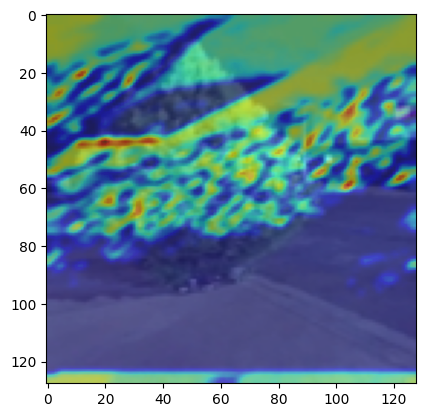

In [ ]:
# Definir Grad-CAM.
def grad_cam(model, img_array, class_idx):
    grad_model = Model(inputs=model.inputs[0],
        outputs=[model.layers[0].output, model.layers[-1].output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    
    # Obtener los gradientes de la capa de convolución.
    grads = tape.gradient(loss, conv_output)

    # Promediar los gradientes.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar la activación por los gradientes promediados.
    conv_output = conv_output[0] # Obtener la imagen activa.
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    # Normalizar el mapa de calor.
    heatmap = np.maximum(heatmap, 0) # Eliminar los valores negativos.
    heatmap /= np.max(heatmap) # Normalizar a [0, 1].

    return heatmap

# Obtener el índice de la clase predicha.
class_idx = predicciones_clase[1]

# Obtener el mapa de calor de Grad-CAM.
heatmap = grad_cam(model, example_image, class_idx)

# Escalar la imagen.
img = np.uint8(255 * X_test[1])
img = cv2.convertScaleAbs(img, alpha=1.5, beta=50)

# Escalar el mapa de calor.
heatmap = np.uint8(255 * heatmap)
heatmap = np.resize(heatmap, (img.shape[0], img.shape[1])) # Redimensionar.
heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)

plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.show()